In [35]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["ex10", "msc04515", "s1rmq4m1", "Na5", "bcsstk18",
                "vibrobox", "cbuckle", "Pres_Poisson", "raefsky4", "vanbody",
                "ct20stif", "cant", "bcircuit", "apache1", "consph"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./model_evaluation.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [36]:
if "running_all" not in globals():
    matrix = "vanbody"  # manually set to run over one matrix
matrix

'vanbody'

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from json import dump
from glob import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, r2_score

In [38]:
TESTING_DATA_SIZE = 1000

df = pd.read_csv(f"data/{matrix}_{TESTING_DATA_SIZE}.csv")
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,vanbody.mat,571,0.000001,57100,23646,500,51342,9.753510e-07,True,108.058719,4.703277e+04,47072,89.915937
1,vanbody.mat,571,0.000001,57100,26524,115,57099,1.494486e-04,False,118.780532,1.196328e+07,47072,99.998249
2,vanbody.mat,571,0.000001,57100,16697,221,57099,1.472826e-05,False,119.566583,6.948947e+06,47072,99.998249
3,vanbody.mat,571,0.000001,57100,2435,301,57099,1.333543e-05,False,120.878682,1.005238e+07,47072,99.998249
4,vanbody.mat,571,0.000001,57100,43255,338,57099,1.030199e-05,False,119.215408,3.476739e+05,47072,99.998249


In [39]:
real_names = {
    "Ridge": "Polynomial Regression",
    "RandomForestRegressor": "Random Forest",
    "KNeighborsRegressor": "K-Nearest Neighbors",
    "XGBRegressor": "XGBoost",
    "LinearSVR": "Support Vector Machine"
}

In [40]:
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df["slowdown"].to_numpy()

In [41]:
p = 1 / 98
1 + (1 / p)

# 1 + (1 / x) = 99
# (1 / x) = 98
# x = 1 / 98

99.00000000000001

In [42]:
models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [real_names[model.steps[-1][1].__class__.__name__] for model in models]
ps = [1/98] + list(np.arange(0.02, 1.01, 0.01))

reports = pd.DataFrame(index=ps, columns=model_names)
reports.head()

,Polynomial Regression,Random Forest,K-Nearest Neighbors,XGBoost,Support Vector Machine
0.010204,NaN,NaN,NaN,NaN,NaN
0.020000,NaN,NaN,NaN,NaN,NaN
0.030000,NaN,NaN,NaN,NaN,NaN
0.040000,NaN,NaN,NaN,NaN,NaN
0.050000,NaN,NaN,NaN,NaN,NaN


In [43]:
hyperparams = {name: {k: v for k, v in model.get_params().items() if "__" in k} 
               for name, model in zip(model_names, models)}
with open(f"./figures/{matrix}/hyperparams.json", "w") as f:
    dump(hyperparams, f, indent=4)

In [44]:
for p in ps:
    for model, name in zip(models, model_names):
        preds = model.predict(X_test)
        y_pred_clas = preds > (1 + (1 / p))
        y_true_clas = y_test > (1 + (1 / p))
        reports.loc[p][name] = {
            "Accuracy": accuracy_score(y_true_clas, y_pred_clas),
            "$F_1$ Score": f1_score(y_true_clas, y_pred_clas, zero_division=0),
            "Precision": precision_score(y_true_clas, y_pred_clas, zero_division=0),
            "Recall": recall_score(y_true_clas, y_pred_clas, zero_division=0),
            r"$F_\beta$ Score ($\beta = 0.5$)": fbeta_score(y_true_clas, y_pred_clas, beta=0.5, zero_division=0),
            r"$F_\beta$ Score ($\beta = 2$)": fbeta_score(y_true_clas, y_pred_clas, beta=2, zero_division=0)
        }

reports.head()

,Polynomial Regression,Random Forest,K-Nearest Neighbors,XGBoost,Support Vector Machine
0.010204,"{'Accuracy': 0.251, '$F_1$ Score': 0.010568031...","{'Accuracy': 0.699, '$F_1$ Score': 0.751033912...","{'Accuracy': 0.732, '$F_1$ Score': 0.784911717...","{'Accuracy': 0.667, '$F_1$ Score': 0.717557251...","{'Accuracy': 0.409, '$F_1$ Score': 0.354098360..."
0.020000,"{'Accuracy': 0.82, '$F_1$ Score': 0.9010989010...","{'Accuracy': 0.91, '$F_1$ Score': 0.9468713105...","{'Accuracy': 0.887, '$F_1$ Score': 0.934492753...","{'Accuracy': 0.907, '$F_1$ Score': 0.945067926...","{'Accuracy': 0.817, '$F_1$ Score': 0.897133220..."
0.030000,"{'Accuracy': 0.851, '$F_1$ Score': 0.919502971...","{'Accuracy': 0.922, '$F_1$ Score': 0.955631399...","{'Accuracy': 0.892, '$F_1$ Score': 0.94, 'Prec...","{'Accuracy': 0.923, '$F_1$ Score': 0.956175298...","{'Accuracy': 0.832, '$F_1$ Score': 0.908296943..."
0.040000,"{'Accuracy': 0.875, '$F_1$ Score': 0.933333333...","{'Accuracy': 0.936, '$F_1$ Score': 0.964285714...","{'Accuracy': 0.906, '$F_1$ Score': 0.948801742...","{'Accuracy': 0.936, '$F_1$ Score': 0.964325529...","{'Accuracy': 0.857, '$F_1$ Score': 0.922994076..."
0.050000,"{'Accuracy': 0.88, '$F_1$ Score': 0.9361702127...","{'Accuracy': 0.94, '$F_1$ Score': 0.9668141592...","{'Accuracy': 0.906, '$F_1$ Score': 0.949189189...","{'Accuracy': 0.935, '$F_1$ Score': 0.964108227...","{'Accuracy': 0.863, '$F_1$ Score': 0.926462694..."


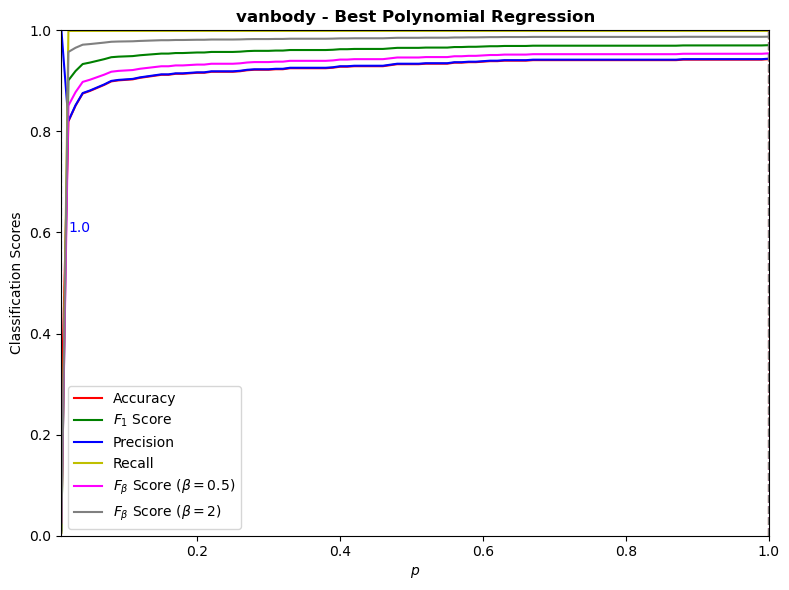

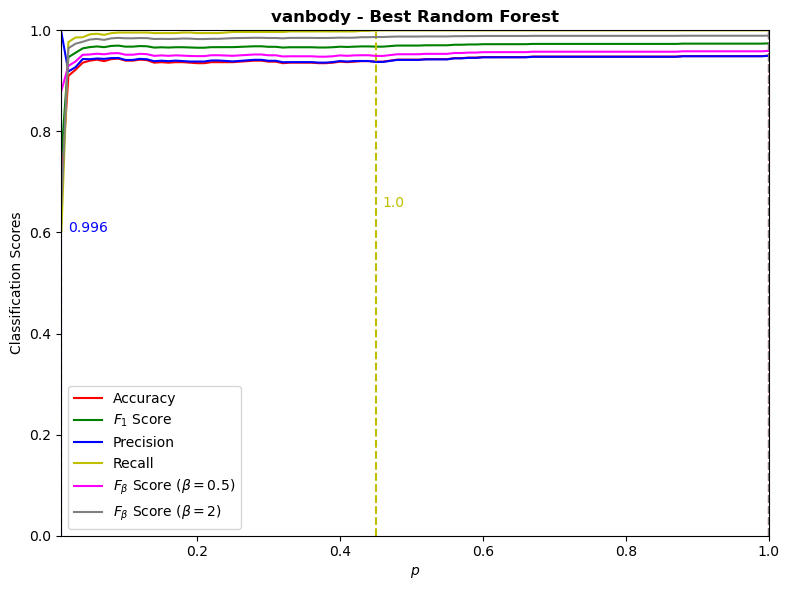

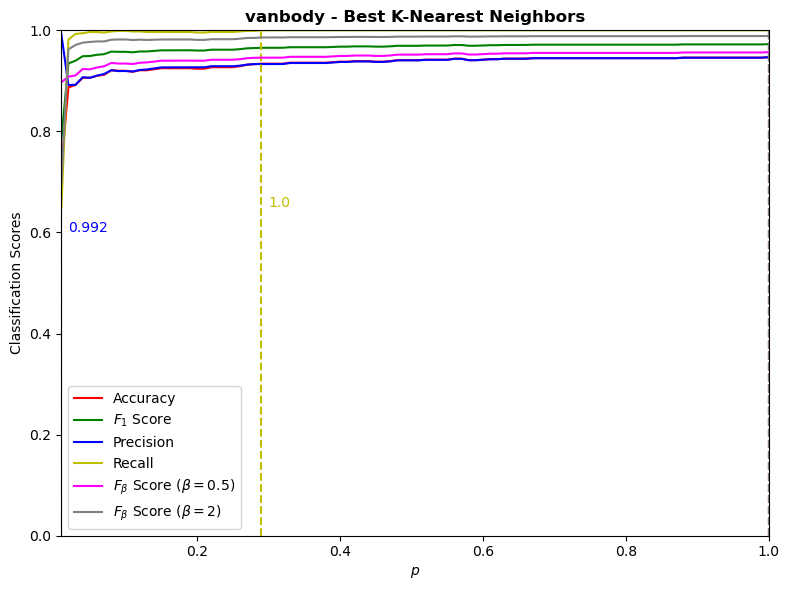

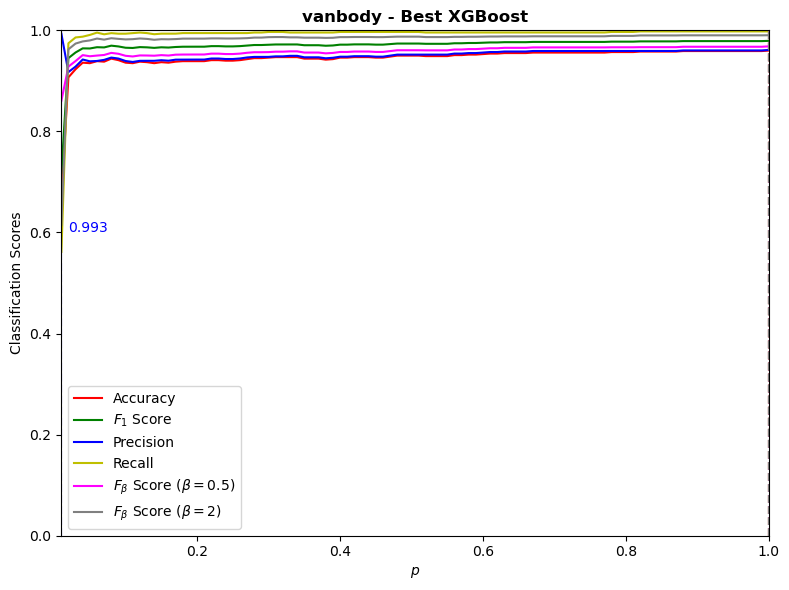

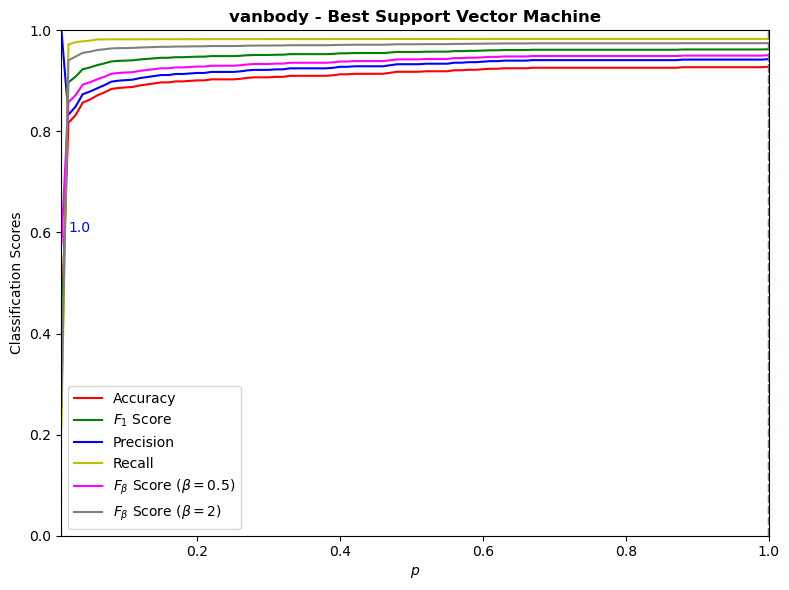

In [45]:
for name, series in reports.items():
    accuracies = [item["Accuracy"] for item in series]
    best_acc_p = ps[np.argmax(accuracies)]
    f1_scores = [scores["$F_1$ Score"] for scores in series]
    best_f1_p = ps[np.argmax(f1_scores)]

    precisions = [scores["Precision"] for scores in series]
    best_precision_p = ps[np.argmax(precisions)]
    recalls = [scores["Recall"] for scores in series]
    best_recall_p = ps[np.argmax(recalls)]

    f1b_05s = [scores[r"$F_\beta$ Score ($\beta = 0.5$)"] for scores in series]
    best_f1b_05_p = ps[np.argmax(f1b_05s)]
    f1b_2s = [scores[r"$F_\beta$ Score ($\beta = 2$)"] for scores in series]
    best_f1b_2_p = ps[np.argmax(f1b_2s)]

    plt.gcf().set_size_inches(8, 6)
    plt.gcf().set_dpi(100)

    plt.plot(ps, accuracies, label="Accuracy", c="r")
    plt.axvline(x=best_acc_p, linestyle='--', c="r")
    plt.annotate(f"{round(np.max(accuracies), 3)}", xy=(best_acc_p + 0.01, 0.5), c="r")

    plt.plot(ps, f1_scores, label="$F_1$ Score", c="g")
    plt.axvline(x=best_f1_p, linestyle='--', c="g")
    plt.annotate(f"{round(np.max(f1_scores), 3)}", xy=(best_f1_p + 0.01, 0.55), c="g")

    plt.plot(ps, precisions, label="Precision", c="b")
    plt.axvline(x=best_precision_p, linestyle='--', c="b")
    plt.annotate(f"{round(np.max(precisions), 3)}", xy=(best_precision_p + 0.01, 0.6), c="b")

    plt.plot(ps, recalls, label="Recall", c="y")
    plt.axvline(x=best_recall_p, linestyle='--', c="y")
    plt.annotate(f"{round(np.max(recalls), 3)}", xy=(best_recall_p + 0.01, 0.65), c="y")

    plt.plot(ps, f1b_05s, label=rf"$F_\beta$ Score ($\beta = 0.5$)", c="magenta")
    plt.axvline(x=best_f1b_05_p, linestyle='--', c="magenta")
    plt.annotate(f"{round(np.max(f1b_05s), 3)}", xy=(best_f1b_05_p + 0.01, 0.7), c="magenta")
    
    plt.plot(ps, f1b_2s, label=rf"$F_\beta$ Score ($\beta = 2$)", c="grey")
    plt.axvline(x=best_f1b_2_p, linestyle='--', c="grey")
    plt.annotate(f"{round(np.max(f1b_2s), 3)}", xy=(best_f1b_2_p + 0.01, 0.75), c="grey")

    plt.title(f"{matrix} - Best {name}", weight="bold")
    plt.xlabel("$p$")
    plt.ylabel("Classification Scores")
    plt.xlim(1/98, 1)
    plt.ylim(0, 1)
    plt.legend()
    os.makedirs(f"./figures/{matrix}", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"./figures/{matrix}/{name}_classification_metrics.png")
    plt.show()

In [46]:
avg_metrics = pd.DataFrame()  # columns=["model", "metric", "value"]

avg_metrics["Accuracy"] = reports.apply(lambda col: np.mean([scores["Accuracy"] for scores in col]))
avg_metrics["$F_1$ Score"] = reports.apply(
    lambda col: np.mean([scores["$F_1$ Score"] for scores in col]))
avg_metrics["Precision"] = reports.apply(lambda col: np.mean([scores["Precision"] for scores in col]))
avg_metrics["Recall"] = reports.apply(lambda col: np.mean([scores["Recall"] for scores in col]))
avg_metrics[r"$F_\beta$ Score ($\beta = 0.5$)"] = reports.apply(
    lambda col: np.mean([scores[r"$F_\beta$ Score ($\beta = 0.5$)"] for scores in col]))
avg_metrics[r"$F_\beta$ Score ($\beta = 2$)"] = reports.apply(
    lambda col: np.mean([scores[r"$F_\beta$ Score ($\beta = 2$)"] for scores in col]))
avg_metrics = avg_metrics.reset_index(names=["model"])
avg_metrics = avg_metrics.melt(id_vars="model", var_name="metric")

avg_metrics

,model,metric,value
0,Polynomial Regression,Accuracy,0.920130
1,Random Forest,Accuracy,0.939970
2,K-Nearest Neighbors,Accuracy,0.934110
3,XGBoost,Accuracy,0.945810
4,Support Vector Machine,Accuracy,0.906890
5,Polynomial Regression,$F_1$ Score,0.952429
6,Random Forest,$F_1$ Score,0.967579
7,K-Nearest Neighbors,$F_1$ Score,0.964777
8,XGBoost,$F_1$ Score,0.970299
9,Support Vector Machine,$F_1$ Score,0.947799


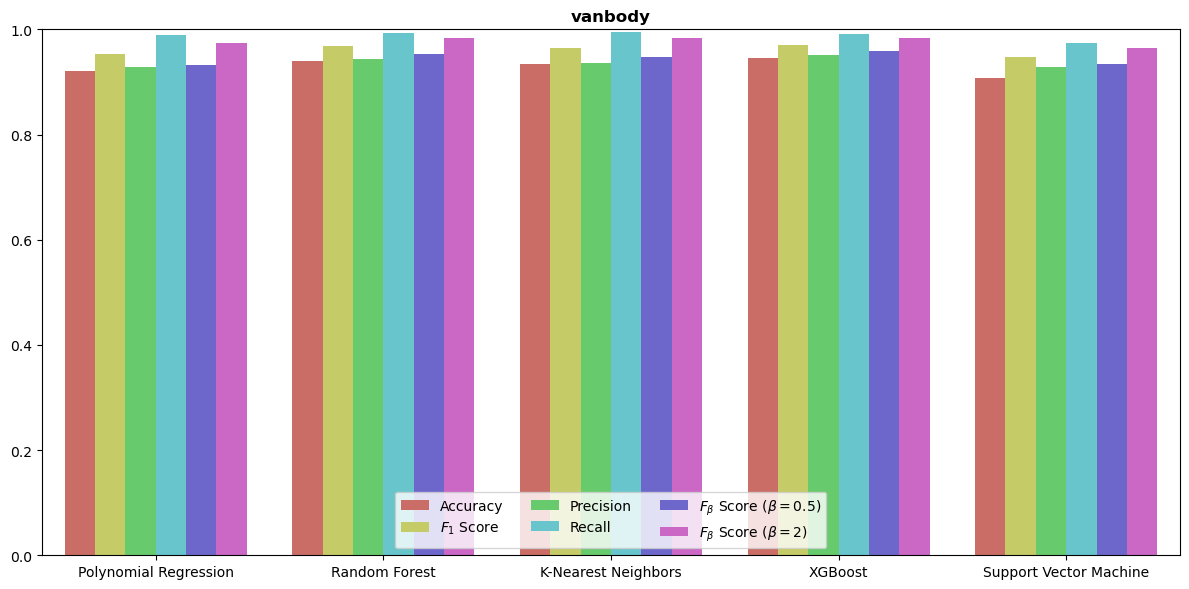

In [47]:
plt.gcf().set_size_inches(12, 6)
plt.gcf().set_dpi(100)
sns.barplot(avg_metrics, x="model", y="value", hue="metric", palette="hls")
plt.ylim(0, 1)
plt.xlabel("")
plt.ylabel("")
plt.title(f"{matrix}", weight="bold")
plt.legend(ncols=3, loc="lower center")
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/avg_metrics_by_model.png")
plt.show()

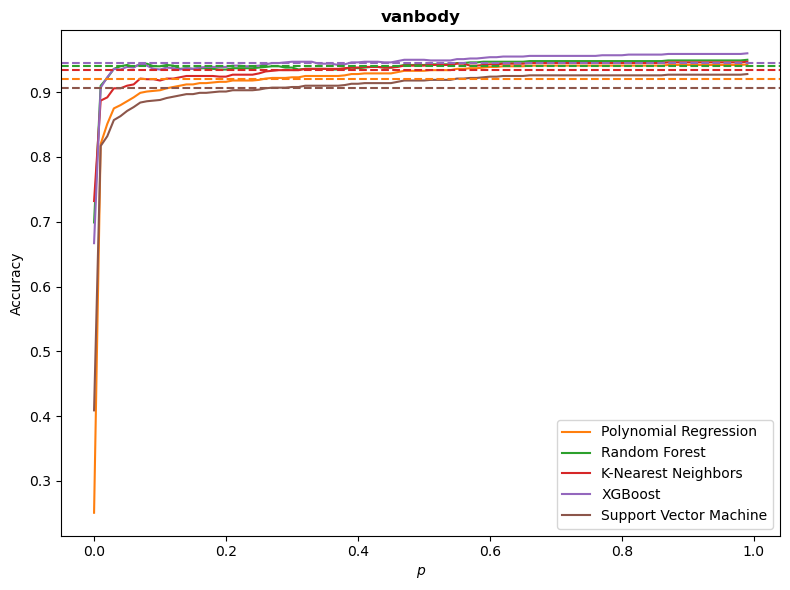

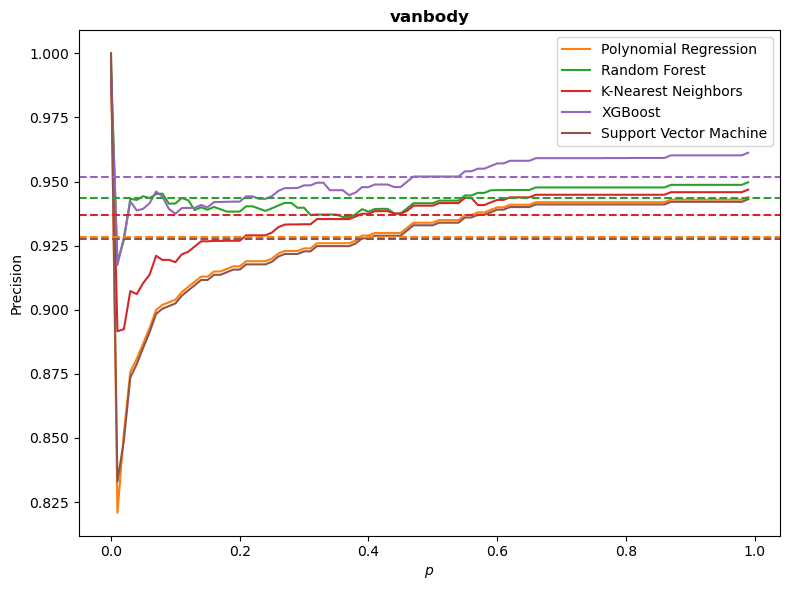

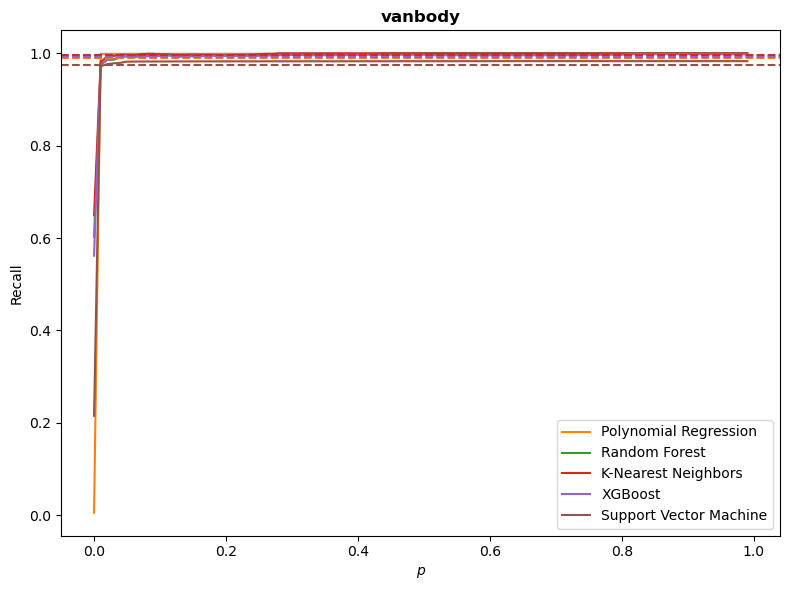

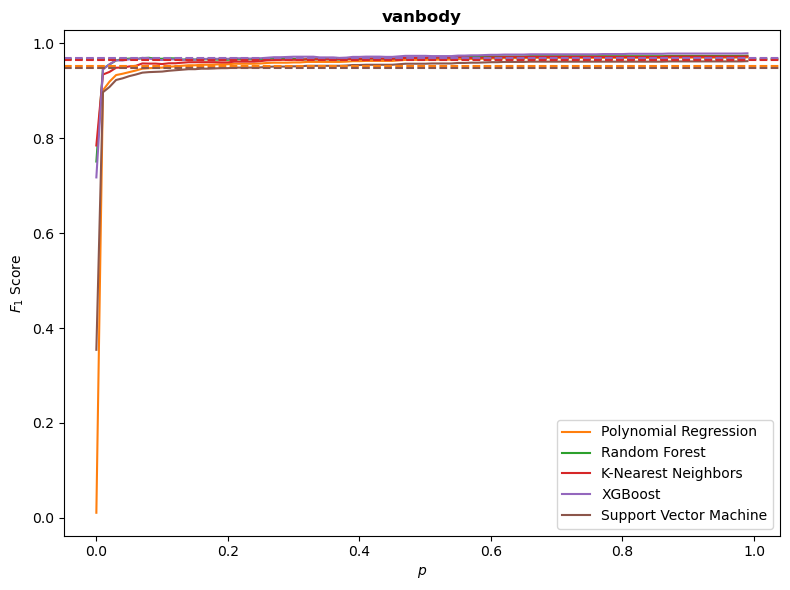

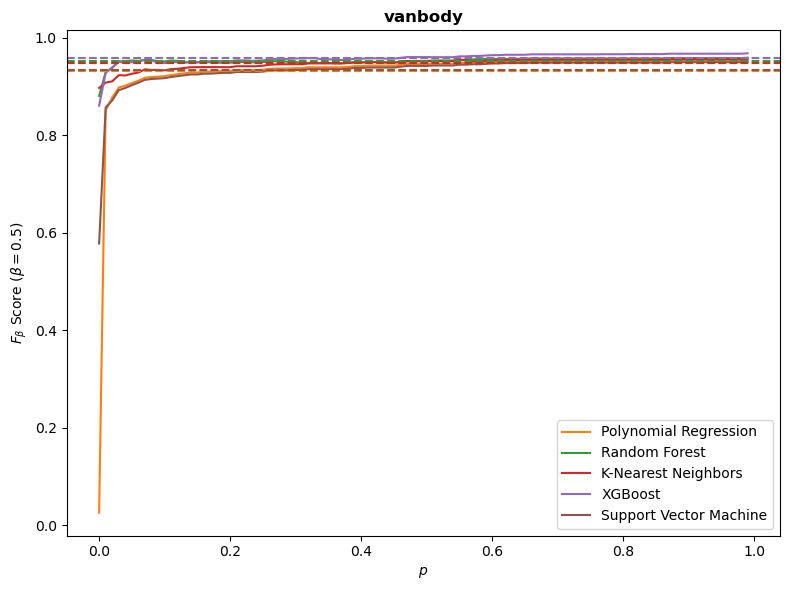

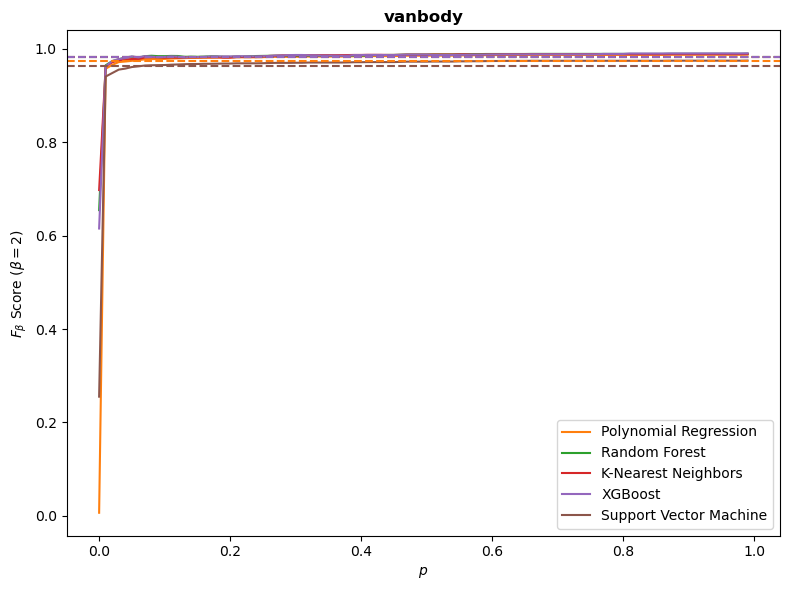

In [48]:
palette = sns.color_palette("tab10", 6)[1:]

for metric in ["Accuracy", "Precision", "Recall", "$F_1$ Score", r"$F_\beta$ Score ($\beta = 0.5$)",
               r"$F_\beta$ Score ($\beta = 2$)"]:
    metrics = pd.DataFrame()
    for name, series in reports.items():
        metrics[name] = [scores[metric] for scores in series]

    plt.gcf().set_size_inches(8, 6)
    plt.gcf().set_dpi(100)

    sns.lineplot(metrics, dashes=False, palette=palette)
    avgs = avg_metrics[avg_metrics["metric"] == metric].drop(columns="metric").reset_index()
    for i, row in avgs.iterrows():
        plt.axhline(y=row["value"], linestyle='--', label=row["model"], c=palette[i])

    plt.xticks([0, 20, 40, 60, 80, 100], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlabel("$p$")
    plt.ylabel(metric)
    plt.title(f"{matrix}", weight="bold")
    plt.tight_layout()
    bs = "\\"
    plt.savefig(f"./figures/{matrix}/{metric.replace('$', '').replace(bs, '')}_by_model.png")
    plt.show()